In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 8.4 MB/s 
     |████████████████████████████████| 895 kB 38.3 MB/s 
     |████████████████████████████████| 67 kB 3.0 MB/s 
     |████████████████████████████████| 6.5 MB 38.7 MB/s 
     |████████████████████████████████| 596 kB 52.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install wordsegment

     |████████████████████████████████| 4.8 MB 5.3 MB/s 


In [3]:
!pip install pyyaml h5py

In [4]:
import numpy as np

import random

import os, json

import pandas as pd
pd.options.display.max_colwidth = 200

import tensorflow as tf
import tensorflow_datasets as tfds

import transformers

from transformers import BertTokenizer, TFBertModel, TrainingArguments, Trainer
from tensorflow.keras import backend as K

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

import re

import logging
tf.get_logger().setLevel(logging.ERROR)

In [5]:
tf.config.list_physical_devices('TPU')

[]

In [6]:
tf.__version__

'2.8.0'

In [7]:
transformers.__version__

'4.17.0'

In [8]:
#Import data from Google drive
from google.colab import drive
drive.mount('/content/gdrive')

korean_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks (1)/Data_Korean_New/korean_train.csv'
                       )

korean_dev = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks (1)/Data_Korean_New/korean_dev.csv'
                       )

korean_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks (1)/Data_Korean_New/korean_test.csv'
                       )

Mounted at /content/gdrive


In [9]:
korean_train

,text,label
0,불쌍해 보이는 이윤 뭘까?~,0
1,독과점의 결과,0
2,별 시덥지않은 악플들은 모냐,0
3,사랑의 불시착 하는시간인데 이상한 노잼 드라마가 하고있다 ㅡㅡ 어딨는거냐 표치수~~~~~,1
4,저밖에몰라..남은사람 어쩌라고. 참 이기적이네,0
...,...,...
5828,다음 생에는 중국 남자 만나야지,0
5829,난 왜 이부진이 생각나는걸까?,0
5830,4년전정준영카톡이 이게 이렇게 큰일이냐?ㅋ 더럽네정말.. 누가봐도 꼬리짜르기구만,1
5831,악플러 쓰레기들 많네,1


In [10]:
korean_dev

,text,label
0,다 그러고 애낳고 키웠고 다 그러고 산다예전에 우리엄마들은 어떻게 애키우며 밭일하고 살았는지...다 본인이 선택한 인생이고 힘든거 이상의 기쁨이 있다기자들도 이런거 퍼날리지말고 발로뛴 기사나 써라,1
1,이제 별 감흥도 없는 애를 멀...,1
2,홍상수 김민희 좋아하는 감독도 배우도 아니지만 남여관계 모르는 거다. 이렇게 비난받을 일은 아닌듯..,0
3,이쁘게 컸네^^,0
4,아니 저 금동현 자리에 진우가 있어야 한다며 ??,0
...,...,...
724,에이프릴 이나은 고정 해도될듯 너무잘하더라♡,0
725,다니엘 잘못한거 없어요 공룡과 힘겨운 분쟁할때당신을 행복하게 해줄 사람 만나는 거ㅡ무조건 응원합니다,0
726,새로운 남자친구나 남편은 저 사이가 얼마나 불편할까,1
727,수아가 불쌍하다 납치되서 20년을 힘들게 살고 남자놈은 수아버리고 민채린한테 가서 다리에서 뛰려고했다 수아가 저둘때메 눈안뒤집히겠냐 그리고 수아정체알고도 부모와못만나게 한채린이를 알게된다면 그집서쫒겨나야죠,0


In [11]:
korean_test

,text,label
0,"팀으로 데뷔한거면 개인활동 했어도 N빵 해야지... 그게 팀을 위해서도 맞는거고~~ 근데 여기 댓글은 다 왜 나누냐는 식이네, 당장 혼자만 배불러야 된다는 심리들인건지, 팀이 유지되야 인기도 오래갈텐데",0
1,왕지혜 34살이지만 외모는 인정한다.여자라면 이정도는 되야지,0
2,여자들이 80프로잉 악플 남자는 여자욕 안해,1
3,설현이 떨고 있다... 아니겠지 아닐거야 그것만은 안돼,0
4,다된 기생충 잔치에재 뿌린 방가방송과 안현모 다신 나서지 말자,1
...,...,...
725,유재석 재벌인디,0
726,보컬만 아니면 상관없잖아..?,0
727,셔누가 무슨 잘뭇했나요? 결백하다...,0
728,사귐 사귄다고 말함되지 참 답답따,0


In [12]:
# # Function to pre-process tweets


# def clean_tweet(tweet):
#   tweet = re.sub(r"\B@\w+", "USERNAME", tweet) #Replace Username
#   tweet = re.sub(r"http\S+", "", tweet) # Remove url

#   hashtags = re.findall(r"(#\w+)", tweet)
#   for hs in hashtags:
#     words = " ".join(ws.segment(hs))
#     if len(words) > 0:
#       tweet = tweet.replace(hs, words)
#     else:
#       tweet = tweet.replace(hs, hs[1:])
  
#   return tweet


In [13]:
# Specify tokenzer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
mbert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
#Tokenize text, see next cell for choice of max_length
max_length = 225



#korean
korean_x_train = tokenizer(list(korean_train.text), 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
korean_y_train = korean_train.label

korean_x_dev = tokenizer(list(korean_dev.text), 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
korean_y_dev = korean_dev.label

korean_x_test = tokenizer(list(korean_test.text), 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
korean_y_test = korean_test.label

In [ ]:
## Clean tweets and then tokenize text

# hindi_train_cleaned = hindi_train
# hindi_train_cleaned.text = hindi_train.text.apply(clean_tweet)

# hindi_dev_cleaned = hindi_dev
# hindi_dev_cleaned.text = hindi_dev.text.apply(clean_tweet)

# hindi_test_cleaned = hindi_test
# hindi_test_cleaned.text = hindi_test.text.apply(clean_tweet)

# #Hindi
# hindi_x_train_cleaned = tokenizer(list(hindi_train_cleaned.text), 
#               max_length=max_length,
#               truncation=True,
#               padding='max_length', 
#               return_tensors='tf')
# hindi_y_train_cleaned = hindi_train_cleaned.label

# hindi_x_dev_cleaned = tokenizer(list(hindi_dev_cleaned.text), 
#               max_length=max_length,
#               truncation=True,
#               padding='max_length', 
#               return_tensors='tf')
# hindi_y_dev_cleaned = hindi_dev_cleaned.label

# hindi_x_test_cleaned = tokenizer(list(hindi_test_cleaned.text), 
#               max_length=max_length,
#               truncation=True,
#               padding='max_length', 
#               return_tensors='tf')
# hindi_y_test_cleaned = hindi_test_cleaned.label

In [15]:
# Max number Non zero elements in input_ids, i.e. longest tokenized sentence for each set, max olength can be *just* more than this
# Choosing 225 in cell above

print(np.apply_along_axis(np.count_nonzero, 1, korean_x_train.input_ids.numpy()).max())
print(np.apply_along_axis(np.count_nonzero, 1, korean_x_dev.input_ids.numpy()).max())
print(np.apply_along_axis(np.count_nonzero, 1, korean_x_test.input_ids.numpy()).max())

94
95
91


In [16]:
def create_classification_model(hidden_sizes = (256, 128), 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam(),
                                hidden_initializer = 'he_uniform',
                                dropout = 0):
    """
    Build a simple classification model with mBERT.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in mbert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = mbert_model(bert_inputs)


    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])


    hidden = tf.keras.layers.Dense(hidden_sizes[0], name='hidden_layer', activation='relu', kernel_initializer = hidden_initializer)(classification_token)
    hidden = tf.keras.layers.LayerNormalization()(hidden)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    hidden = tf.keras.layers.Dense(hidden_sizes[1], name='hidden_layer_2', activation='relu')(hidden)
    hidden = tf.keras.layers.LayerNormalization()(hidden)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=['acc',f1_m,precision_m, recall_m])


    return classification_model

In [17]:
# Custom Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [18]:
# Early stopping callback
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', 
                                                 mode = 'max',
                                                 patience=3, 
                                                 restore_best_weights=True)

In [19]:
#Function to add arecord to a json file
def append_record(record):
    with open('/content/gdrive/MyDrive/Colab Notebooks (1)/Models_Korean_22_4_2/settings_history.txt', 'a') as f:
        json.dump(record, f)
        f.write(os.linesep)

In [22]:
#hyperparameter tuning
random.seed(42)
learning_rates = [.001]
dropouts = [0, 0.15, 0.2]
hidden_sizes = [(256, 128)]
train_layers = [0]


count = 0
for learning_rate in learning_rates:
  for dropout in dropouts:
    for train_layer in train_layers:
      for hidden_size in hidden_sizes:

        count += 1

        if count <= 2:
          continue


        settings = {'count':count,
                    'learning_rate':learning_rate,
                    'dropout':dropout,
                    'train_layer':train_layer,
                    'hidden_size':hidden_size
                    }

        #Define checkpoint directory
        checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks (1)/Models_Korean_22_4_2/training_" + str(count) + "/cp.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)

        classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(learning_rate), 
                                                    train_layers = train_layer,
                                                    hidden_initializer = 'he_uniform',
                                                    dropout = dropout,
                                                    hidden_sizes = hidden_size
                                                    )
        
        
        # Create a callback that saves the model's weights
        cp_callback = [early_stopper, tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=0)]

        # Train the model with the new callback
        print('COUNT = {:.0f}'.format(count))
        history = classification_model.fit([korean_x_train.input_ids, korean_x_train.token_type_ids, korean_x_train.attention_mask],
                          korean_y_train,
                          validation_data=([korean_x_dev.input_ids, korean_x_dev.token_type_ids, korean_x_dev.attention_mask],
                          korean_y_dev),
                                epochs=15,
                                batch_size=20,
                                callbacks=cp_callback,
                                verbose = 1
                                )
        

        append_record({'setings':settings, 'history':history.history})


      

COUNT = 3
Epoch 1/15
292/292 [==============================] - 84s 265ms/step - loss: 0.6887 - acc: 0.5891 - f1_m: 0.5690 - precision_m: 0.5946 - recall_m: 0.6037 - val_loss: 0.7034 - val_acc: 0.5364 - val_f1_m: 0.2272 - val_precision_m: 0.7387 - val_recall_m: 0.1392
Epoch 2/15
292/292 [==============================] - 74s 252ms/step - loss: 0.6503 - acc: 0.6240 - f1_m: 0.6032 - precision_m: 0.6365 - recall_m: 0.6514 - val_loss: 0.6268 - val_acc: 0.6639 - val_f1_m: 0.6572 - val_precision_m: 0.6786 - val_recall_m: 0.6539
Epoch 3/15
292/292 [==============================] - 74s 252ms/step - loss: 0.6333 - acc: 0.6391 - f1_m: 0.6166 - precision_m: 0.6416 - recall_m: 0.6493 - val_loss: 0.6105 - val_acc: 0.6749 - val_f1_m: 0.6946 - val_precision_m: 0.6580 - val_recall_m: 0.7508
Epoch 4/15
292/292 [==============================] - 74s 253ms/step - loss: 0.6266 - acc: 0.6465 - f1_m: 0.6357 - precision_m: 0.6467 - recall_m: 0.6695 - val_loss: 0.6278 - val_acc: 0.6571 - val_f1_m: 0.6209 - v

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')

settings_history_1 = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks (1)/Models_22_3_26/settings_history.txt', lines = True
                       )

settings_history_2 = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks (1)/Models_22_3_27/settings_history.txt', lines = True
                       )

settings_history = pd.concat([settings_history_1, settings_history_2], axis = 0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import json
with open('/content/gdrive/MyDrive/Colab Notebooks (1)/Models_22_3_26/settings_history.txt') as f:
    settings_history_1 = [json.loads(line) for line in f]

with open('/content/gdrive/MyDrive/Colab Notebooks (1)/Models_22_3_27/settings_history.txt') as f:
    settings_history_2 = [json.loads(line) for line in f]

settings_history = settings_history_1 + settings_history_2

In [ ]:
len(settings_history)

36

In [ ]:
history_df = pd.DataFrame(columns = ['count', 'learning_rate','dropout','train_all_layer','hidden_size','epochs','train_acc','val_acc','train_f1','val_f1'])

for i in range(len(settings_history)):

  max_val_f1 = max(settings_history[i]['history']['val_f1_m'])
  max_index = settings_history[i]['history']['val_f1_m'].index(max_val_f1) 
  
  history_df.loc[i] = [settings_history[i]['setings']['count'], 
                       settings_history[i]['setings']['learning_rate'],
                       settings_history[i]['setings']['dropout'],
                       settings_history[i]['setings']['train_layer'],
                       tuple(settings_history[i]['setings']['hidden_size']),
                       max_index + 1,
                       settings_history[i]['history']['acc'][max_index],
                       settings_history[i]['history']['val_acc'][max_index],
                       settings_history[i]['history']['f1_m'][max_index],
                       settings_history[i]['history']['val_f1_m'][max_index]
                       ]



In [ ]:
history_df

,count,learning_rate,dropout,train_all_layer,hidden_size,epochs,train_acc,val_acc,train_f1,val_f1
0,1,0.00100,0,0,"(64, 32)",5,0.645573,0.667297,0.627301,0.696761
1,2,0.00100,0,0,"(128, 64)",3,0.623849,0.614367,0.606010,0.688045
2,3,0.00100,0,0,"(256, 128)",6,0.645337,0.640832,0.618001,0.705075
3,4,0.00100,0,-1,"(64, 32)",9,0.655962,0.654064,0.632794,0.699915
4,5,0.00100,0,-1,"(128, 64)",2,0.614640,0.640832,0.571690,0.666652
5,6,0.00100,0,-1,"(256, 128)",1,0.569303,0.601134,0.512847,0.670555
6,7,0.00100,0.15,0,"(64, 32)",6,0.630224,0.644612,0.610441,0.697905
7,8,0.00100,0.15,0,"(128, 64)",4,0.621724,0.625709,0.594425,0.691327
8,9,0.00100,0.15,0,"(256, 128)",1,0.556553,0.620038,0.511237,0.644344
9,10,0.00100,0.15,-1,"(64, 32)",1,0.563400,0.625709,0.535674,0.654108


In [ ]:
print(history_df.groupby('learning_rate').mean()['val_f1'])

print(history_df.groupby('dropout').mean()['val_f1'])
print(history_df.groupby('train_all_layer').mean()['val_f1'])
print(history_df.groupby('hidden_size').mean()['val_f1'])

learning_rate
0.00005    0.653893
0.00010    0.674767
0.00100    0.684402
Name: val_f1, dtype: float64
dropout
0.00    0.668044
0.15    0.673997
Name: val_f1, dtype: float64
train_all_layer
-1    0.672259
 0    0.669782
Name: val_f1, dtype: float64
hidden_size
(64, 32)      0.665669
(128, 64)     0.669031
(256, 128)    0.678362
Name: val_f1, dtype: float64


(0.0, 4.0)

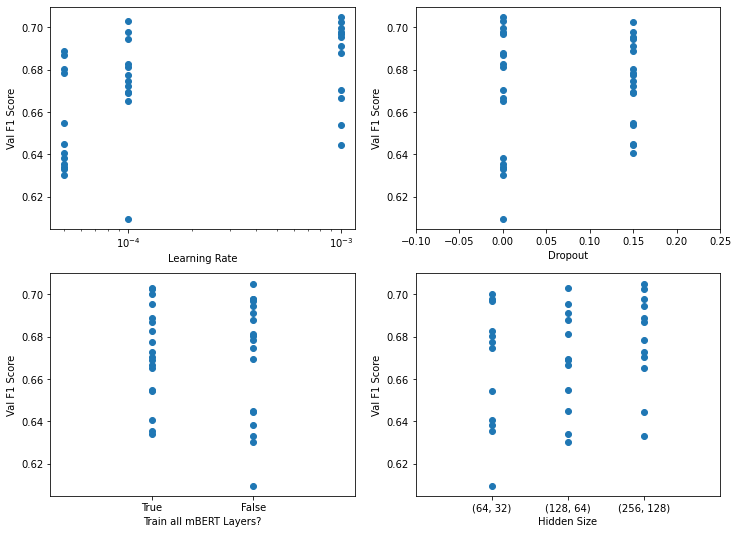

In [ ]:
f, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 9))

axes[0][0].scatter(history_df.learning_rate, history_df.val_f1)
axes[0][0].set_xlabel('Learning Rate')
axes[0][0].set_ylabel('Val F1 Score')
axes[0][0].set_xscale("log");

axes[0][1].scatter(history_df.dropout, history_df.val_f1)
axes[0][1].set_xlabel('Dropout')
axes[0][1].set_ylabel('Val F1 Score')
axes[0][1].set_xlim([-.1, .25])


axes[1][0].scatter(history_df.train_all_layer, history_df.val_f1)
axes[1][0].set_xlabel('Train all mBERT Layers?')
axes[1][0].set_ylabel('Val F1 Score')
axes[1][0].set_xticks([-1, 0])
axes[1][0].set_xticklabels(['True', 'False'])
axes[1][0].set_xlim([-2, 1])



hidden_dict = { (64, 32) : 1, 
               (128, 64) : 2, 
               (256,128) : 3 }

axes[1][1].scatter(history_df.hidden_size.apply(lambda x:hidden_dict[x]), history_df.val_f1)
axes[1][1].set_xlabel('Hidden Size')
axes[1][1].set_ylabel('Val F1 Score')
axes[1][1].set_xticks([1, 2, 3])
axes[1][1].set_xticklabels(['(64, 32)', '(128, 64)', '(256, 128)'])
axes[1][1].set_xlim([0, 4])




In [ ]:
history_df.hidden_size

0       (64, 32)
1      (128, 64)
2     (256, 128)
3       (64, 32)
4      (128, 64)
5     (256, 128)
6       (64, 32)
7      (128, 64)
8     (256, 128)
9       (64, 32)
10     (128, 64)
11    (256, 128)
12      (64, 32)
13     (128, 64)
14    (256, 128)
15      (64, 32)
16     (128, 64)
17    (256, 128)
18      (64, 32)
19     (128, 64)
20    (256, 128)
21      (64, 32)
22     (128, 64)
23    (256, 128)
24      (64, 32)
25     (128, 64)
26    (256, 128)
27      (64, 32)
28     (128, 64)
29    (256, 128)
30      (64, 32)
31     (128, 64)
32    (256, 128)
33      (64, 32)
34     (128, 64)
35    (256, 128)
Name: hidden_size, dtype: object

#Previous Code

In [ ]:
classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(), 
                                                   train_layers = 0,
                                                   hidden_initializer = 'he_uniform',
                                                   dropout = False
                                                   )
classification_model.summary()

In [ ]:
classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(), 
                                                   train_layers = 0,
                                                   hidden_initializer = 'he_uniform',
                                                   dropout = False
                                                   )
classification_model.summary()

In [ ]:
#Define checkpoint directory
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
classification_model.fit([hindi_x_train.input_ids, hindi_x_train.token_type_ids, hindi_x_train.attention_mask],
                         hindi_y_train,
                         validation_data=([hindi_x_dev.input_ids, hindi_x_dev.token_type_ids, hindi_x_dev.attention_mask],
                         hindi_y_dev),
                        epochs=10,
                        batch_size=16,
                         callbacks=[cp_callback])

In [ ]:
# reload saved model
model = create_classification_model(optimizer=tf.keras.optimizers.Adam(), 
                                                   train_layers = 0,
                                                   hidden_initializer = 'he_uniform',
                                                   dropout = False
                                                   )

# Loads the weights
model.load_weights(checkpoint_path)


In [ ]:
predictions = model.predict([hindi_x_dev.input_ids, hindi_x_dev.token_type_ids, hindi_x_dev.attention_mask])

In [ ]:
Analysis = pd.DataFrame(data = {'predicted_prob':predictions.reshape(529,), 'predicted_class':(predictions>0.5).reshape(529).astype(int),'true_class':hindi_y_dev})

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(list(Analysis.true_class), list(Analysis.predicted_class), labels=[0, 1])
print(confusion_matrix)

In [ ]:
Analysis['correct_prediction'] = Analysis.predicted_class == Analysis.true_class

In [ ]:
Analysis.reset_index(drop=True, inplace=True)

In [ ]:
# Correctly classified as toxic with the largest probability
pd.set_option('display.max_colwidth', None)

temp_df = Analysis[(Analysis.correct_prediction==True) & (Analysis.true_class == 1)].nlargest(25, ['predicted_prob'])

pd.concat([hindi_df_dev.iloc[list(temp_df.index)], temp_df[['predicted_prob', 'correct_prediction']]], axis = 1)

In [ ]:
# Correctly classified as non-toxic with the lowest probability (of toxic)
pd.set_option('display.max_colwidth', None)

temp_df = Analysis[(Analysis.correct_prediction==True) & (Analysis.true_class == 0)].nsmallest(25, ['predicted_prob'])

pd.concat([hindi_df_dev.iloc[list(temp_df.index)], temp_df[['predicted_prob', 'correct_prediction']]], axis = 1)

In [ ]:
# incorrectly classified as toxic with the highest probability (of toxic)
pd.set_option('display.max_colwidth', None)


temp_df = Analysis[(Analysis.correct_prediction==False) & (Analysis.true_class == 0)].nlargest(25, ['predicted_prob'])

pd.concat([hindi_df_dev.iloc[list(temp_df.index)], temp_df[['predicted_prob', 'correct_prediction']]], axis = 1)

In [ ]:
# incorrectly classified as non-toxic with the lowest probability (of toxic)
pd.set_option('display.max_colwidth', None)


temp_df = Analysis[(Analysis.correct_prediction==False) & (Analysis.true_class == 1)].nsmallest(25, ['predicted_prob'])

pd.concat([hindi_df_dev.iloc[list(temp_df.index)], temp_df[['predicted_prob', 'correct_prediction']]], axis = 1)

In [ ]:
# Model is unsure, predicted prob is abs(predicted_prob - 0.5)

pd.set_option('display.max_colwidth', None)


temp_df = Analysis.predicted_prob.sub(0.5).abs().nsmallest(25)

pd.concat([hindi_df_dev.iloc[list(temp_df.index)], temp_df], axis = 1).rename(columns={'predicted_prob':'abs(predicted_prob - 0.5)'})


In [ ]:
outputs = mbert_model(hindi_x_dev.input_ids[:5], hindi_x_dev.token_type_ids[:5], hindi_x_dev.attention_mask[:5], output_attentions=True )

In [ ]:
outputs